In [1]:
import time
import math
import logging 
import random
import itertools

import pandas as pd
import numpy as np
from numpy import where
import scipy as sci
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from collections import Counter

# imblearn
from imblearn.over_sampling import RandomOverSampler as ros
from imblearn.under_sampling import RandomUnderSampler as rus
from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling, combine

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold


import catboost as cb
import xgboost as xgb
import seaborn as sns
from scipy.stats import spearmanr
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin


# save model
import pickle

# Helper Functions

In [2]:
def generate_model_report(y_actual, y_predicted):
    print('Accuracy = ', accuracy_score(y_actual, y_predicted))
    print('Precision = ', precision_score(y_actual, y_predicted))
    print('Recall = ', recall_score(y_actual, y_predicted))
    print('F1 Score = ', f1_score(y_actual, y_predicted))
    pass

In [3]:
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label='AUC ROC Curve with Area Under the Curve = '+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

In [4]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [2]:
# # Plot Confusion Matrix
# plot_confusion_matrix(model, X_test, y_test,
#                       cmap=pyplot.cm.Blues,
#                       normalize='true',
#                      display_labels=['Foreclosed', 'Not Foreclosed'])
# pyplot.grid(False)
# pyplot.title("XGBoost Confusion Matrix on Test Set")
# pyplot.savefig('../Figures/Models/confusion_matrix.png')
# pyplot.show()

# Data

In [3]:
# Read column names from file
cols = ['Monthly Reporting Period', 'Origination Date', 'Maturity Date', 'Loan Identifier']
df = pd.read_csv('../CSV_Files//Final_Clean_Data.csv', index_col=0).drop(cols, axis = 'columns')

In [4]:
df.head()

,Current Interest Rate,Original UPB,Original Loan Term,Loan Age,Original Loan to Value Ratio (LTV),Number of Borrowers,Debt-To-Income (DTI),First Time Home Buyer Indicator,Modification Flag,Home Ready Program Indicator,High Balance Loan Indicator,Minimum Credit Score,Foreclosed
0,3.750,65000,360,59,74,1,31,0,0,0,0,814,0
1,4.000,153000,360,58,95,2,17,0,0,0,0,788,0
2,3.625,114000,360,54,95,2,37,1,0,0,0,745,0
3,3.875,150000,360,56,70,2,16,0,0,0,0,810,0
4,4.250,40000,360,59,24,2,36,0,0,0,0,755,0


## Current distribution for our imbalanced target

In [5]:
# class count
class_count_0, class_count_1 = df['Foreclosed'].value_counts()

# Separate class
class_0 = len(df[df['Foreclosed'] == 0])
class_1 = len(df[df['Foreclosed'] == 1])

print('class 0:', class_0)
print('class 1:', class_1)

class 0: 8255841
class 1: 22816


## Defining our data for train_test_split on imbalanced data

In [6]:
# # define dataset
X = df[['Current Interest Rate', 'Original UPB', 'Original Loan Term',
       'Loan Age', 'Original Loan to Value Ratio (LTV)', 'Number of Borrowers',
       'Debt-To-Income (DTI)', 'First Time Home Buyer Indicator',
       'Modification Flag', 'Home Ready Program Indicator',
       'High Balance Loan Indicator', 'Minimum Credit Score']
]
y = df['Foreclosed']

Loans that are not foreclosed: 8255841
Loans that are foreclosed:     22816


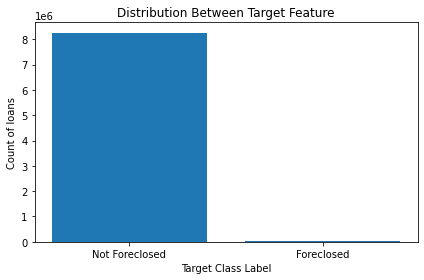

Zero: 8255841 
One: 22816


In [7]:
plt.rcParams.update({'axes.facecolor':'white'})
print(f'Loans that are not foreclosed: {class_0}')
print(f'Loans that are foreclosed:     {class_1}')

plt.bar(['Not Foreclosed', 'Foreclosed'], [class_0, class_1])
plt.title('Distribution Between Target Feature')
plt.xlabel('Target Class Label')
plt.ylabel('Count of loans')
plt.grid(False)

plt.tight_layout()
plt.savefig('../Notebook_images/Target_Feature_Distrbution')
plt.show()

print(f'Zero: {class_0} \nOne: {class_1}')

In [45]:
100 * (22816/float(df.shape[0]))

0.2756002573847425

In [46]:
100 * (8255841/float(df.shape[0]))

99.72439974261526

## Scatter plot of target feature

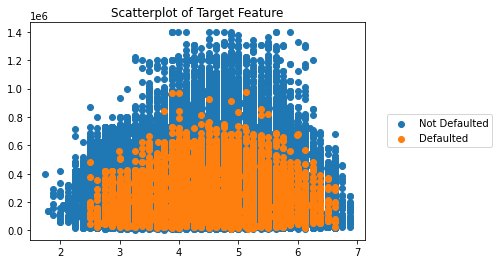

In [16]:
# scatter plot of examples by class label
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')

counter = Counter(y)
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X.iloc[row_ix, 0], X.iloc[row_ix, 1])
plt.title('Scatterplot of Target Feature')
plt.legend(["Not Defaulted","Defaulted"],
           bbox_to_anchor = (1.05, 0.6))

plt.savefig('../Notebook_images/Distribution.png')
plt.show();

# Over and Under Sampling

In [14]:
# example of random oversampling to balance the class distribution
# Combining Random Oversampling and Undersampling
counter = Counter(y)
# summarize class distribution
print(f'  Initial Data: {counter}')

# define undersampling strategy
under = rus(sampling_strategy=0.5)

# fit and apply the transform
X_under, y_under = under.fit_resample(X, y)
count_y = Counter(y_under)
# summarize class distribution
print(f'Under sampling: {count_y}')

# define oversampling strategy
over = SMOTE(sampling_strategy=0.7)
# fit and apply the transform
X_over, y_over = over.fit_resample(X_under, y_under)
# summarize class distribution
counter_o = Counter(y_over)
print(f' Over sampling: {counter_o}')


  Initial Data: Counter({0: 8255841, 1: 22816})
Under sampling: Counter({0: 45632, 1: 22816})
 Over sampling: Counter({0: 45632, 1: 31942})


### under sampling train_test_split

In [15]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size=0.33, random_state=42)

### over sampling train_test_split

In [16]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_over, y_over, test_size=0.33, random_state=42)

# Under Sampling Data Logistic Regression

In [20]:
clf = LogisticRegression().fit(X_train_u, y_train_u)
y_test_pred = clf.predict(X_test_u)

In [21]:
y_train_u.value_counts()

0    30585
1    15275
Name: Foreclosed, dtype: int64

In [136]:
print('Logistic Regression Undersampling')
print(classification_report(y_test_u, y_test_pred))
df_matrix=pd.DataFrame(confusion_matrix(y_test_u, y_test_pred), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test_u, y_test_pred).ravel()
print("True Negatives:  ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives:  ",tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')


Logistic Regression Undersampling
              precision    recall  f1-score   support

           0       0.74      0.88      0.81     15047
           1       0.62      0.39      0.48      7541

    accuracy                           0.72     22588
   macro avg       0.68      0.64      0.64     22588
weighted avg       0.70      0.72      0.70     22588

True Negatives:   13254
False Positives:  1793
False Negatives:  4586
True Positives:   2955

Accuracy 71.76%:


,Predicted False,Predicted True
Actual False,13254,1793
Actual True,4586,2955


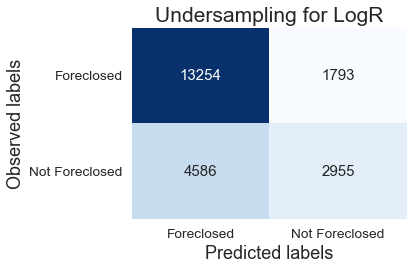

In [116]:
cm = confusion_matrix(y_test_u, y_test_pred)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Undersampling for LogR', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/UndersamplingLogR')
plt.show()

In [18]:
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test_u, y_test_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  13294
False Positives:  1753
False Negatives:  4532
True Positives:  3009


In [19]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

Accuracy 72.18%:


# SMOTE Logistic Regression Over Sampling Data

In [17]:
# import logistic regression model and accuracy_score metric
logR = LogisticRegression() 

In [18]:
# Training the model on our training dataset
logR.fit(X_train_o, y_train_o)

LogisticRegression()

In [19]:
predictions = logR.predict(X_test_o)

In [20]:
print('Logistic Regression SMOTE Oversampling')
print(classification_report(y_test_o, predictions))
df_matrix=pd.DataFrame(confusion_matrix(y_test_o, predictions), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test_o, predictions).ravel()
print("True Negatives:  ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives:  ",tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')


Logistic Regression SMOTE Oversampling
              precision    recall  f1-score   support

           0       0.69      0.84      0.76     15087
           1       0.66      0.45      0.54     10513

    accuracy                           0.68     25600
   macro avg       0.68      0.65      0.65     25600
weighted avg       0.68      0.68      0.67     25600

True Negatives:   12673
False Positives:  2414
False Negatives:  5750
True Positives:   4763

Accuracy 68.11%:


,Predicted False,Predicted True
Actual False,12673,2414
Actual True,5750,4763


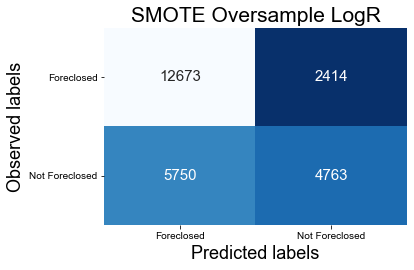

In [21]:
cm = confusion_matrix(y_test_o, predictions)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('SMOTE Oversample LogR', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/SMOTE_Oversample_LogR')
plt.show()

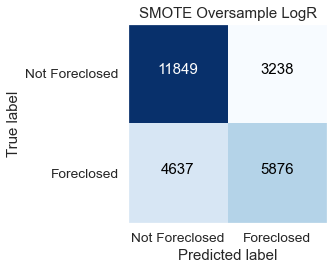

In [26]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_o, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(cnf_matrix, classes=['Not Foreclosed','Foreclosed'],
                      title='SMOTE Oversample LogR')

In [34]:
# predicting probabilities for the test data
prob_test_set = logR.predict_proba(X_test_o)#, predictions

In [35]:
# Computing Area Under the ROC Curve from prediction scores.

AUC_ROC = roc_auc_score(y_test_o, prob_test_set[:,1]) #<shift + tab> to learn more
#prob_test_set[:,1] will gives the probabilities for all 1 ([0.5 to 1.0]) and 0 ([0 to 0.49])

print('Area Under ROC Curve: %.2f%%' % ((AUC_ROC)*100))

Area Under ROC Curve: 74.36%


In [36]:
# Computing Receiver operating characteristic (ROC)
fpr, tpr, thresholds = roc_curve(y_test_o, prob_test_set[:,1])

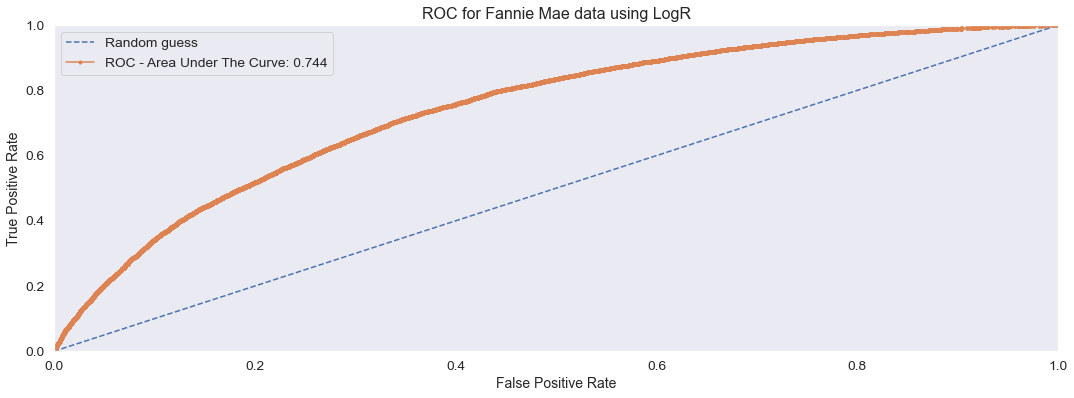

In [37]:
# Let's get the plot now!
# plot no skill - A line for random guess
plt.figure(figsize=(18,6))
plt.plot([0, 1], [0, 1], linestyle='--', label = 'Random guess' )

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label = 'ROC - Area Under The Curve: %.3f' % AUC_ROC)

# let's set the limits (0,1)
plt.xlim([0, 1])
plt.ylim([0, 1])

# good to put title and labels
plt.title('ROC for Fannie Mae data using LogR', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.grid(False)
# putting the legends  
plt.legend();

# Decision Tree Using Under Sampling Data

> example of random oversampling to balance the class distribution
> Combining Random Oversampling and Undersampling
> 
> define undersampling strategy
> under = rus(sampling_strategy=0.5)
>
> fit and apply the transform
> X_under, y_under = under.fit_resample(X, y)



**split the data and use the undersampling we did using SMOTE**

In [122]:
#Using the train_test_split to create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state = 42, test_size = 0.25)

In [123]:
#Importing the Decision tree classifier from the sklearn library.
from sklearn.tree import DecisionTreeClassifier
clf_u = DecisionTreeClassifier(criterion = 'entropy')

**we will fit the classifier on the train attributes and labels.**

In [124]:
#Training the decision tree classifier. 
clf_u.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

**we will use the trained classifier/ model to predict the labels of the test attributes.**

In [125]:
#Predicting labels on the test set.
y_pred =  clf_u.predict(X_test)

**We will now evaluate the predicted classes using some metrics. For this case, we will use 'accuracy_score' to calculate the accuracy of the predicted labels**

In [137]:
print('Decision Tree Using Under Sampling')
print(classification_report(y_test, y_pred))
df_matrix=pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives:  ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives:  ",tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')

Decision Tree Using Under Sampling
              precision    recall  f1-score   support

           0       0.76      0.75      0.75     11384
           1       0.51      0.52      0.52      5728

    accuracy                           0.67     17112
   macro avg       0.64      0.64      0.64     17112
weighted avg       0.68      0.67      0.68     17112

True Negatives:   8548
False Positives:  2836
False Negatives:  2729
True Positives:   2999

Accuracy 67.48%:


,Predicted False,Predicted True
Actual False,8548,2836
Actual True,2729,2999


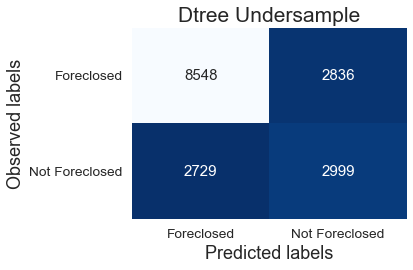

In [130]:
cm = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Dtree Undersample', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/Dtree_Undersample')
plt.show()

In [127]:
XTrain, XTest, YTrain, YTest = train_test_split(X_under, y_under, random_state=42)
dtmodel = DecisionTreeClassifier(criterion='entropy', min_samples_split=100).fit(XTrain,YTrain)
YPred = dtmodel.predict(XTest)

accuracy = accuracy_score(YTest,YPred)
report = classification_report(YPred, YTest)
cm = confusion_matrix(YTest, YPred)

print("Classification report:")
print(report)
print('Accracy: %.2f%%' % (accuracy_score(YTest, YPred)*100))
print()
print("Confusion matrix:")
print(cm)


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80     12113
           1       0.53      0.61      0.57      4999

    accuracy                           0.73     17112
   macro avg       0.68      0.69      0.69     17112
weighted avg       0.74      0.73      0.73     17112

Accracy: 72.95%

Confusion matrix:
[[9434 1950]
 [2679 3049]]


In [35]:
print('Accuracy Score on train data: %.2f%%' % accuracy_score(y_true=y_train, y_pred=clf_u.predict(X_train)* 100))
print('Accuracy Score on test data:  %.2f%%' % accuracy_score(y_true=y_test, y_pred=(y_pred)*100))

Accuracy Score on train data: 0.67%
Accuracy Score on test data:  0.50%


**tune the parameters of the decision tree to increase its accuracy.**

In [36]:
clf_u_hyper = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
clf_u_hyper.fit(X_train, y_train)

print('Accuracy Score on train data:    %.2f%%' % accuracy_score(y_true=y_train, y_pred=clf_u_hyper.predict(X_train) * 100))
print('Accuracy Score on the test data: %.2f%%' % accuracy_score(y_true=y_test, y_pred=clf_u_hyper.predict(X_test)* 100))

Accuracy Score on train data:    0.59%
Accuracy Score on the test data: 0.54%


## Saving Model

In [37]:
# save the model to disk
filename = '../Models/DTree_Hyper_Fitted_undersampling.sav'
pickle.dump(clf_u_hyper, open(filename, 'wb'))

# Decision Tree Using Over Sampling Data

> example of random oversampling to balance the class distribution
> Combining Random Oversampling and Undersampling
> 
> define oversampling strategy
> over = SMOTE(sampling_strategy=0.7)
>
> fit and apply the transform
> X_over, y_over = over.fit_resample(X_under, y_under)


In [38]:
#Using the train_test_split to create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state = 47, test_size = 0.25)

In [39]:
clf_o = DecisionTreeClassifier(criterion = 'entropy')

In [40]:
#Training the decision tree classifier. 
clf_o.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [41]:
#Predicting labels on the test set.
y_pred =  clf_o.predict(X_test)

In [42]:
print('Accuracy Score on train data:    %.2f%%' % accuracy_score(y_true=y_train, y_pred=clf_o.predict(X_train) * 100))
print('Accuracy Score on the test data: %.2f%%' % accuracy_score(y_true=y_test, y_pred= (y_pred)* 100))

Accuracy Score on train data:    0.59%
Accuracy Score on the test data: 0.43%


**tune the parameters of the decision tree to increase its accuracy.**

In [43]:
clf_o_hyper = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
clf_o_hyper.fit(X_train, y_train)
# print('Accuracy Score on train data: %.2f%%' % accuracy_score(y_true=y_train, y_pred = clf_o_hyper.predict(X_train)))
# print('Accuracy Score on the test data: %.2f%%' % accuracy_score(y_true=y_test, y_pred = clf_o_hyper.predict(X_test)))

print('Accuracy Score on train data:    %.2f%%' % accuracy_score(y_true=y_train, y_pred = clf_o_hyper.predict(X_train) * 100))
print('Accuracy Score on the test data: %.2f%%' %  accuracy_score(y_true=y_test, y_pred = clf_o_hyper.predict(X_test)* 100))

Accuracy Score on train data:    0.51%
Accuracy Score on the test data: 0.46%


In [61]:

XTrain, XTest, YTrain, YTest = train_test_split(X_over, y_over, random_state=42)
dtmodel = DecisionTreeClassifier(criterion='entropy', min_samples_split=50).fit(XTrain,YTrain)
YPred = dtmodel.predict(XTest)

accuracy = accuracy_score(YTest,YPred)
report = classification_report(YPred, YTest)
cm = confusion_matrix(YTest, YPred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)


Classification report:
Accuracy:  0.7135196452511086
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     11683
           1       0.64      0.66      0.65      7711

    accuracy                           0.71     19394
   macro avg       0.70      0.70      0.70     19394
weighted avg       0.72      0.71      0.71     19394

Confusion matrix:
[[8782 2655]
 [2901 5056]]


In [138]:
print('Decision Tree Using Over Sampling')
print(classification_report(YTest,YPred))
df_matrix=pd.DataFrame(confusion_matrix(YTest,YPred), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(YTest,YPred).ravel()

print("True Negatives: ", tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ", tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')

Decision Tree Using Over Sampling
              precision    recall  f1-score   support

           0       0.78      0.83      0.80     11384
           1       0.61      0.53      0.57      5728

    accuracy                           0.73     17112
   macro avg       0.69      0.68      0.69     17112
weighted avg       0.72      0.73      0.72     17112

True Negatives:  9434
False Positives:  1950
False Negatives:  2679
True Positives:  3049

Accuracy 72.95%:


,Predicted False,Predicted True
Actual False,9434,1950
Actual True,2679,3049


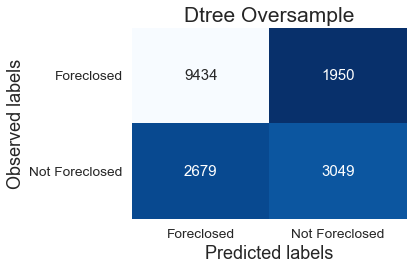

In [131]:
cm = confusion_matrix(YTest,YPred)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Dtree Oversample', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/Dtree_Oversample')
plt.show()

In [44]:
# save the model to disk
filename = 'DTree_Hyper_Fitted_oversampling.sav'
pickle.dump(clf_o_hyper, open(filename, 'wb'))

# Random Forest with Under Sampling

In [38]:
forest_u = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-100)
forest_u.fit(X_train_u, y_train_u)

RandomForestClassifier(n_jobs=-100, random_state=42)

In [39]:
y_pred_rf_under = forest_u.predict(X_test_u)
print('Accracy: %.2f%%' % (accuracy_score(y_test_u, y_pred_rf_under)*100))

Accracy: 74.52%


**Classification Report**

In [64]:
print(classification_report(y_test_u, y_pred_rf_under))
df_matrix=pd.DataFrame(confusion_matrix(y_test_u, y_pred_rf_under), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
print('Accracy: %.2f%%' % (accuracy_score(y_test_u, y_pred_rf_under)*100))
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.78      0.85      0.82     15047
           1       0.64      0.53      0.58      7541

    accuracy                           0.75     22588
   macro avg       0.71      0.69      0.70     22588
weighted avg       0.74      0.75      0.74     22588

Accracy: 74.52%


,Predicted False,Predicted True
Actual False,12817,2230
Actual True,3525,4016


In [142]:
print('Random Forest Under Sampling')
print(classification_report(y_test_u, y_pred_rf_under))
df_matrix=pd.DataFrame(confusion_matrix(y_test_u, y_pred_rf_under), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test_u, y_pred_rf_under).ravel()

print("True Negatives:  ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives:  ",tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')

Random Forest Under Sampling
              precision    recall  f1-score   support

           0       0.78      0.85      0.82     15047
           1       0.64      0.53      0.58      7541

    accuracy                           0.75     22588
   macro avg       0.71      0.69      0.70     22588
weighted avg       0.74      0.75      0.74     22588

True Negatives:   12817
False Positives:  2230
False Negatives:  3525
True Positives:   4016

Accuracy 74.52%:


,Predicted False,Predicted True
Actual False,12817,2230
Actual True,3525,4016


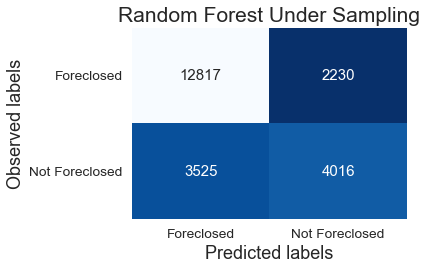

In [143]:
cm = confusion_matrix(y_test_u, y_pred_rf_under)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Random Forest Under Sampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/RandomForestUnderSampling')
plt.show()

In [48]:
# save the model to disk
filename = '../Models/RandomForest_undersampling.sav'
pickle.dump(y_pred_rf_under, open(filename, 'wb'))

# Random Forest with Over Sampling

In [41]:
forest_o = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-100)
forest_o.fit(X_train_o, y_train_o)

RandomForestClassifier(n_jobs=-100, random_state=42)

In [42]:
y_pred_rf_over = forest_o.predict(X_test_o)
print('Accracy: %.2f%%' % (accuracy_score(y_test_o, y_pred_rf_over)*100))

Accracy: 76.26%


**Classification Report**

In [65]:
print(classification_report(y_test_o, y_pred_rf_over))
df_matrix=pd.DataFrame(confusion_matrix(y_test_o, y_pred_rf_over), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
print('Accracy: %.2f%%' % (accuracy_score(y_test_o, y_pred_rf_over)*100))
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     15087
           1       0.72      0.69      0.71     10513

    accuracy                           0.76     25600
   macro avg       0.76      0.75      0.75     25600
weighted avg       0.76      0.76      0.76     25600

Accracy: 76.26%


,Predicted False,Predicted True
Actual False,12257,2830
Actual True,3247,7266


In [145]:
print('Random Forest Over Sampling')
print(classification_report(y_test_o, y_pred_rf_over))
df_matrix=pd.DataFrame(confusion_matrix(y_test_o, y_pred_rf_over), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
#extracting true_positives, false_positives, true_negatives, false_negatives
tn, fp, fn, tp = confusion_matrix(y_test_o, y_pred_rf_over).ravel()

print("True Negatives:  ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives:  ",tp)
print()
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}%:".format(Accuracy))

df_matrix.style.background_gradient(cmap='Blues')

Random Forest Over Sampling
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     15087
           1       0.72      0.69      0.71     10513

    accuracy                           0.76     25600
   macro avg       0.76      0.75      0.75     25600
weighted avg       0.76      0.76      0.76     25600

True Negatives:   12257
False Positives:  2830
False Negatives:  3247
True Positives:   7266

Accuracy 76.26%:


,Predicted False,Predicted True
Actual False,12257,2830
Actual True,3247,7266


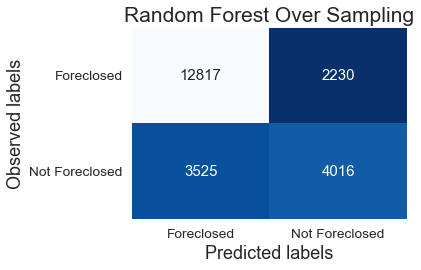

In [146]:
cm = confusion_matrix(y_test_u, y_pred_rf_under)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Random Forest Over Sampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/RandomForestOvererSampling')
plt.show()

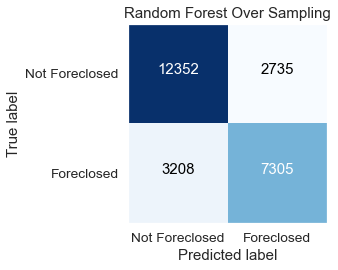

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_o, y_pred_rf_over)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(cnf_matrix, classes=['Not Foreclosed','Foreclosed'],
                      title='Random Forest Over Sampling')

In [53]:
# save the model to disk
filename = '../Models/RandomForest_oversampling.sav'
pickle.dump(y_pred_rf_over, open(filename, 'wb'))

# XGBoost Under Sampling train_test_split

In [44]:
#Using the train_test_split to create train and test sets.
X_train_xgb_u, X_test_xgb_u, y_train_xgb_u, y_test_xgb_u = train_test_split(X_under, y_under, random_state = 42, test_size = 0.25)

In [45]:

# fit model on training data
model_xgb_under = XGBClassifier(eval_metric='mlogloss')
model_xgb_under.fit(X_train_xgb_u, y_train_xgb_u)

# make predictions for test data
predictions = model_xgb_under.predict(X_test_xgb_u)

print(model_xgb_under)

# evaluate predictions
accuracy = accuracy_score(y_test_xgb_u, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
Accuracy: 75.35%


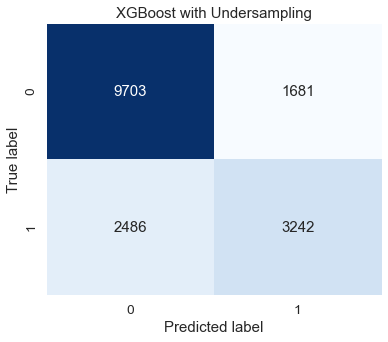

In [56]:
# Create a confusion matrix
conf_mat = confusion_matrix(y_test_xgb_u, predictions) 
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='', cbar=False, cmap='Blues' )
plt.title('XGBoost with Undersampling')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

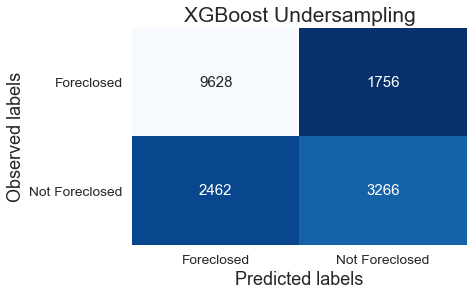

In [46]:
cm_xgb_u = confusion_matrix(y_test_xgb_u, predictions)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm_xgb_u, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('XGBoost Undersampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.savefig('../Notebook_images/XGBoost_Oversample')
plt.show()

In [58]:
# save the model to disk
filename = '../Models/model_xgb_under.sav'
pickle.dump(model_xgb_under, open(filename, 'wb'))

## k-fold cross validation evaluation of xgboost model using under sampling

In [47]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# CV model
model_xgb_kfold_under = XGBClassifier(eval_metric='mlogloss')
kfold = KFold(n_splits=10)

print(model_xgb_kfold_under)

results = cross_val_score(model_xgb_kfold_under, X_train_xgb_u, y_train_xgb_u, cv=kfold)
print("Accuracy: %.2f%% Standard Deviation: (%.2f%%)" % (results.mean()*100, results.std()*100))

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
Accuracy: 75.27% Standard Deviation: (0.64%)


In [61]:
# save the model to disk
filename = '../Models/model_xgb_kfold_under.sav'
pickle.dump(model_xgb_kfold_under, open(filename, 'wb'))

# XGBoost Over Sampling train_test_split

In [48]:
#Using the train_test_split to create train and test sets.
X_train_xgb_o, X_test_xgb_o, y_train_xgb_o, y_test_xgb_o = train_test_split(X_over, y_over, random_state = 42, test_size = 0.25)

In [50]:
# fit model on training data
model_xgb_over = XGBClassifier(eval_metric='mlogloss')
model_xgb_over.fit(X_train_xgb_o, y_train_xgb_o)

# make predictions for test data
predictions = model_xgb_under.predict(X_test_xgb_o)

print(model_xgb_under)

# evaluate predictions
accuracy = accuracy_score(y_test_xgb_o, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
Accuracy: 76.44%


In [51]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.44%


In [52]:
print(classification_report(y_test_xgb_o, predictions))
df_matrix=pd.DataFrame(confusion_matrix(y_test_xgb_o, predictions), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     11437
           1       0.76      0.62      0.68      7957

    accuracy                           0.76     19394
   macro avg       0.76      0.74      0.75     19394
weighted avg       0.76      0.76      0.76     19394



,Predicted False,Predicted True
Actual False,9860,1577
Actual True,2992,4965


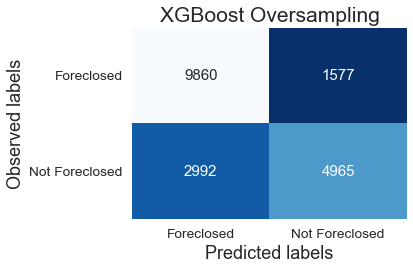

In [57]:
cm_xgb_o = confusion_matrix(y_test_xgb_o, predictions)

ax = plt.subplot()
sns.set(font_scale=1.25) # Adjust to fit
sns.heatmap(cm_xgb_o, annot=True, ax=ax, cmap="Blues_r", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('XGBoost Oversampling', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelrotation=0)  # Adjust to fit
ax.xaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
ax.yaxis.set_ticklabels(['Foreclosed', 'Not Foreclosed']);
plt.tight_layout()
plt.savefig('../Notebook_images/XGBoost_OversamplingMatrix')
plt.show()

In [67]:
# save the model to disk
filename = '../Models/model_xgb_over.sav'
pickle.dump(model_xgb_over, open(filename, 'wb'))

## k-fold cross validation evaluation of xgboost model using over sampling

In [54]:
# k-fold cross validation evaluation of xgboost model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# CV model
model_xgb_kfold_over = XGBClassifier(eval_metric='mlogloss')
model_5 = model_xgb_kfold_over.fit(X_train_xgb_o, y_train_xgb_o)
kfold = KFold(n_splits=10)
pred_kfold = model_5.predict(X_test_xgb_o)
print(model_5)

results = cross_val_score(model_xgb_kfold_over, X_train_xgb_o, y_train_xgb_o, cv=kfold)
print("Accuracy: %.2f%% Standard Deviation: (%.2f%%)" % (results.mean()*100, results.std()*100))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
Accuracy: 77.62% Standard Deviation: (0.55%)


In [55]:
print(classification_report(y_test_xgb_o, pred_kfold))
df_matrix=pd.DataFrame(confusion_matrix(y_test_xgb_o, pred_kfold), 
             columns=["Predicted False", "Predicted True"], 
             index=["Actual False", "Actual True"])
df_matrix.style.background_gradient(cmap='Blues')

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     11437
           1       0.74      0.70      0.72      7957

    accuracy                           0.77     19394
   macro avg       0.77      0.76      0.76     19394
weighted avg       0.77      0.77      0.77     19394



,Predicted False,Predicted True
Actual False,9438,1999
Actual True,2397,5560


In [70]:
# save the model to disk
filename = '../Models/model_xgb_kfold_over.sav'
pickle.dump(model_xgb_kfold_over, open(filename, 'wb'))